In [1]:
import ipynb.fs.full.preProcessing as preProcess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import json
import seaborn as sns

LGA Name : object
Region : object
2011 : float64
2012 : float64
2013 : float64
2014 : float64
2015 : float64
2016 : float64
2017 : float64
2018 : float64
2019 : float64
2020 : float64
Year : int64
Year ending : object
Police Region : object
Local Government Area : object
Offence Count : object
Rate per 100,000 population : object
Year : int64
Year ending : object
Police Region : object
Local Government Area : object
Offence Count : float64
Rate per 100,000 population : float64
IRSD (min)
IRSD (max)
IRSD (avg)
Check union of LGA:  56


DECISION TREE MODEL:

FULL SET REGRESSOR:
Features: 

All 79 features from communities (with 2 extra features for distance), housing price at t-1, egm at t-1, offence rate at t-1 => Predict the offence rate at t

(t in [2015, 2016] to ensure the communities data are still relevant)

Use continuous output directly

In [2]:
# Preparing the frame for training model
offences = preProcess.cleanedOffences
offences = offences.drop(columns=["Year ending", "Police Region", "Offence Count"])

communities = preProcess.cleanedCommunities
communities["Distance from Melbourne"] = np.sqrt(communities["Location_x"]**2 + communities["Location_y"]**2)
communities["Direction from Melbourne"] = np.arctan(communities["Location_x"]/ communities["Location_y"])

housingPrices = preProcess.cleanedHousingPrice
egm = preProcess.cleanedEgm


In [3]:
from sklearn.preprocessing import OneHotEncoder

modelData = offences[(offences["Year"] == 2015) | (offences["Year"] == 2016)]
modelData = pd.merge(left=modelData, right=communities, how="left", on="LGA")

for idx, row in modelData.iterrows():
    modelData.loc[idx, "Last Offence Rate"] = offences[(offences["LGA"] == row["LGA"]) 
                                            & (offences["Year"] == row["Year"] - 1)]["Rate per 100,000 population"].iloc[0]
    modelData.loc[idx, "Last Housing Price"] = housingPrices.loc[row["LGA"]][str(row["Year"] - 1)]
    modelData.loc[idx, "Last EGM"] = egm.loc[row["LGA"]][str(row["Year"] - 1)]


In [4]:

# One hot the LGA - Use inverse transform from the encoder to get back the lga

oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["LGA"]).reshape(-1, 1))
oneHotLGA = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["LGA"]).reshape(-1, 1))
                         .toarray())
modelData = modelData.join(oneHotLGA)
modelData = modelData.drop(columns=["LGA"])

modelData.columns = modelData.columns.astype('str')

modelData

,Year,"Rate per 100,000 population",Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),ARIA+ (avg),Commercial (km^2),Industrial (km^2),Residential (km^2),...,46,47,48,49,50,51,52,53,54,55
0,2016,7903.7,20.289781,84.535123,0.000000,0.000000,0.000000,0.008991,0.021552,0.605656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016,9375.1,19.419507,128.349256,0.000000,0.000000,0.000000,0.016543,0.213052,0.474939,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016,10864.1,14.544640,45.693749,0.000000,0.000000,0.000000,0.029054,0.067348,0.697212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016,7166.8,16.202194,65.887204,0.000000,0.000000,0.000000,0.010994,0.107162,0.366402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,11420.0,23.587200,599.996103,0.023828,0.037001,0.029642,0.016390,0.026318,0.094048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2015,11385.6,384.960766,23359.313312,2.687931,3.482185,3.087847,0.000074,0.000461,0.001773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,2015,6857.1,58.368445,2142.863230,0.331739,0.880712,0.598316,0.000394,0.002019,0.020584,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,2015,9876.3,179.410340,6720.196354,2.135649,2.837918,2.452597,0.000128,0.000423,0.002905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,2015,5198.3,94.497165,1652.413568,0.512327,0.704602,0.606605,0.000191,0.000432,0.016410,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
def getSplitAttributes(tree_rules: str):
    # Parsing the split attributes
    splitAtts = []
    AttRegex = r".*\|--- ([^<>=]*) [<>=].*"

    for line in tree_rules.split("\n"):
        # print(line)
        matchObj = re.match(AttRegex, line)
        if matchObj:
            att = matchObj.group(1)
            splitAtts.append(att)
            # print(att)
    return splitAtts

In [ ]:
# Define models here
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

models = {
    "regressor": 
}

MSE Error of decision tree regressor:  697081.9242945275
MSE Ada:  811343.4798173137
MSE rf: 1288704.4687022867
MSE Error of null mean model:  19575059.038002674
MSE Error of null last model:  938340.3716666667
Ratio regressor/null1:  0.035610718871459085
Ratio regressor/null2:  0.7428881303022065
Ratio ada/null2:  0.8646579688095665
Ratio rf/null2:  1.37338700072481


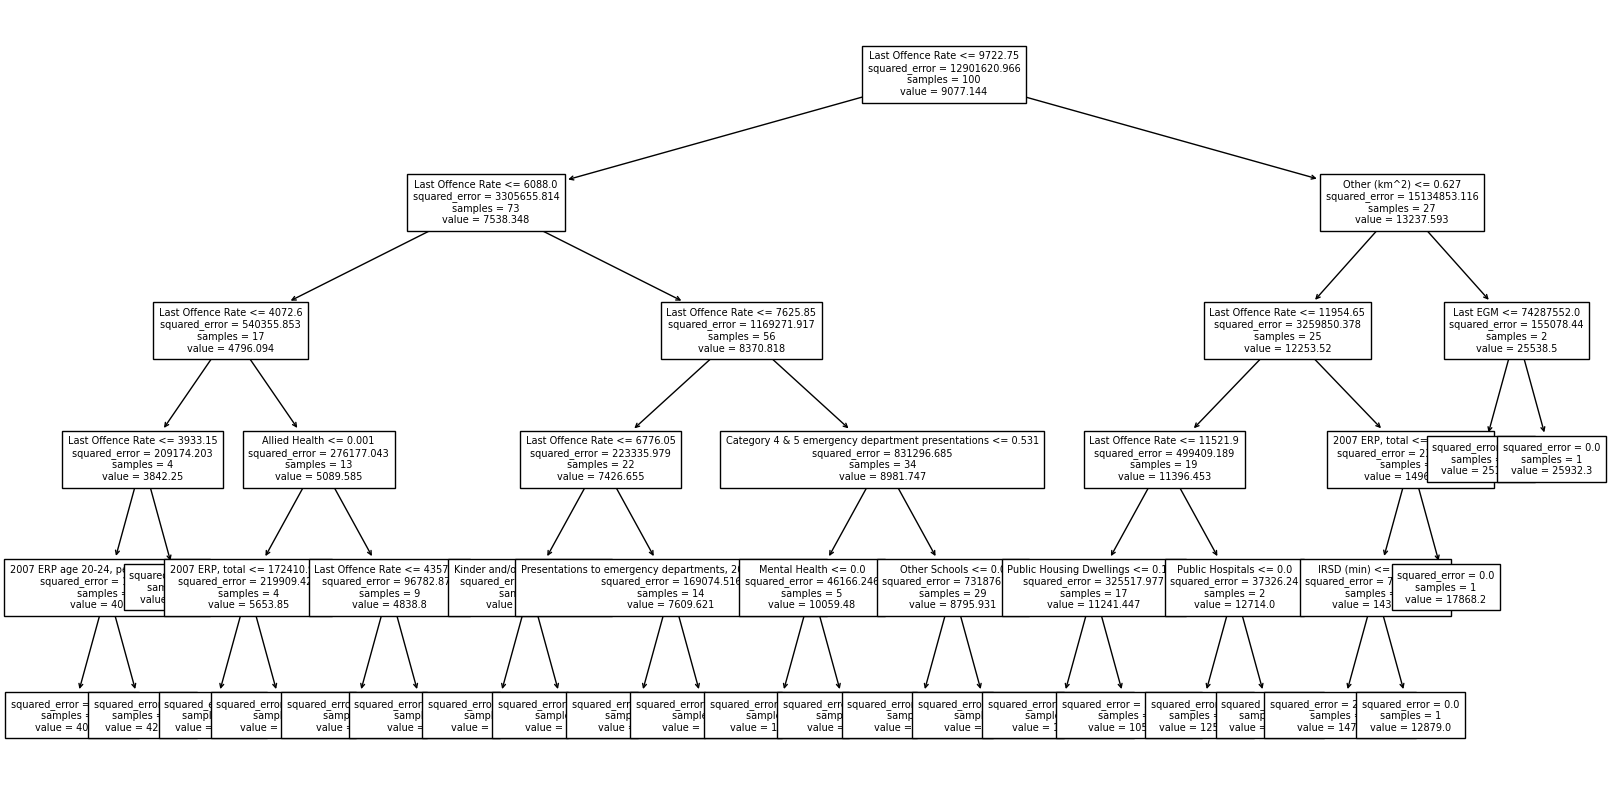

|--- Last Offence Rate <= 9722.75
|   |--- Last Offence Rate <= 6088.00
|   |   |--- Last Offence Rate <= 4072.60
|   |   |   |--- Last Offence Rate <= 3933.15
|   |   |   |   |--- 2007 ERP age 20-24, persons <= 0.08
|   |   |   |   |   |--- value: [4012.50]
|   |   |   |   |--- 2007 ERP age 20-24, persons >  0.08
|   |   |   |   |   |--- value: [4267.20]
|   |   |   |--- Last Offence Rate >  3933.15
|   |   |   |   |--- value: [3076.80]
|   |   |--- Last Offence Rate >  4072.60
|   |   |   |--- Allied Health <= 0.00
|   |   |   |   |--- 2007 ERP, total <= 172410.95
|   |   |   |   |   |--- value: [6377.40]
|   |   |   |   |--- 2007 ERP, total >  172410.95
|   |   |   |   |   |--- value: [5412.67]
|   |   |   |--- Allied Health >  0.00
|   |   |   |   |--- Last Offence Rate <= 4357.45
|   |   |   |   |   |--- value: [4617.20]
|   |   |   |   |--- Last Offence Rate >  4357.45
|   |   |   |   |   |--- value: [4949.60]
|   |--- Last Offence Rate >  6088.00
|   |   |--- Last Offence Rate <

In [6]:
# Use hold out for now
from sklearn.tree import plot_tree, export_text

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Models: https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/
# AdaBoost model (TODO: Recheck source): Train an initial tree with uniform weight for all points.
# Then, for subsequent iterations, change the weights so more weights are given for
# the points with errors.
# Then, random selection based on the normalized probability weights for the data points
# to construct a new datasets => Train a new tree on top of it 
# At the end, with 300 iterations, around 300 decision trees are built and used for regression

DEPTH = 5
decisionTreeRegressor = DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267)
adaboostRegressor = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=DEPTH), n_estimators=400, random_state=1301266
)
rf = RandomForestRegressor(n_estimators=100, max_depth=DEPTH)

X = modelData.drop(columns=["Rate per 100,000 population", "Year"])
y = modelData["Rate per 100,000 population"]

# 19 random state yields some odd precision, likely due to how the split is constructed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=100)

decisionTreeRegressor.fit(X_train, y_train)
adaboostRegressor.fit(X_train, y_train)
rf.fit(X_train, y_train)

y_predict = decisionTreeRegressor.predict(X_test)
y_predict2 = adaboostRegressor.predict(X_test)
y_predict3 = rf.predict(X_test)

y_null_predict = [y_train.mean()] * len(X_test)
y_null_2 = X_test["Last Offence Rate"]

mse_regressor = mean_squared_error(y_test, y_predict)
mse_ada = mean_squared_error(y_test, y_predict2)
mse_rf = mean_squared_error(y_test, y_predict3)

mse_null = mean_squared_error(y_test, y_null_predict)
mse_null_2 = mean_squared_error(y_test, y_null_2)


print("MSE Error of decision tree regressor: ", mse_regressor)
print("MSE Ada: ", mse_ada)
print("MSE rf:",  mse_rf)
print("MSE Error of null mean model: ", mse_null)
print("MSE Error of null last model: ", mse_null_2)
print("Ratio regressor/null1: ", mse_regressor/mse_null)
print("Ratio regressor/null2: ", mse_regressor/mse_null_2)
print("Ratio ada/null2: ", mse_ada/mse_null_2)

print("Ratio rf/null2: ", mse_rf/mse_null_2)

# Check the decision tree regressor
fig, axe = plt.subplots(figsize=(20,10))
plot_tree(decisionTreeRegressor, 
          feature_names=X_train.columns,
          ax=axe, 
          fontsize=7)
plt.show()

# Use text
tree_rules = export_text(decisionTreeRegressor, feature_names=list(X_train))
print(tree_rules)

print("Concise list of attributes")
print(pd.Series(getSplitAttributes(tree_rules)).value_counts())



MSE of null : 13371022.861005904
RMSE of null : 2946.637238268595
MSE of null2 : 884194.9589666666
RMSE of null2 : 798.1495043702108
MSE of ada : 881901.5770950861
RMSE of ada : 785.0860698509221
MSE of regressor : 2612330.657170017
RMSE of regressor : 1098.0737180247077
Key precision comparison ratio
Ada/Null2 0.9974062486464969
0.06595617898964093
Regressor/Null2 2.954473592818232
0.19537253689008283
Used attributes for regressor tree: 
Last Offence Rate               1296
Public Housing Dwellings          96
Last EGM                          84
Public Hospitals                  82
Distance from Melbourne           80
                                ... 
ARIA+ (min)                        2
2007 ERP age 70-74, persons        2
Speaks LOTE at home, persons       2
Direction from Melbourne           2
Residential (km^2)                 2
Name: count, Length: 94, dtype: int64


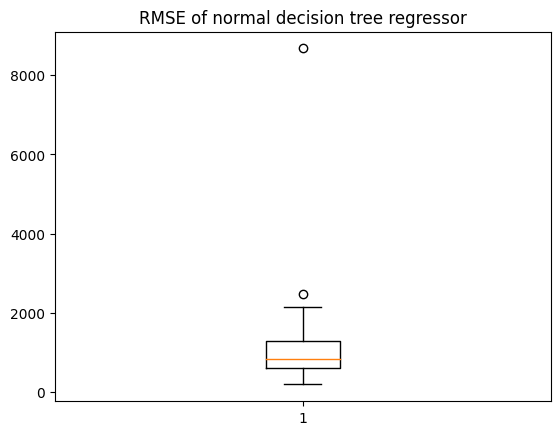

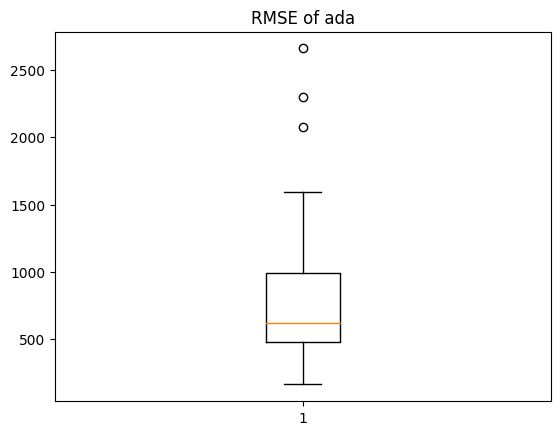

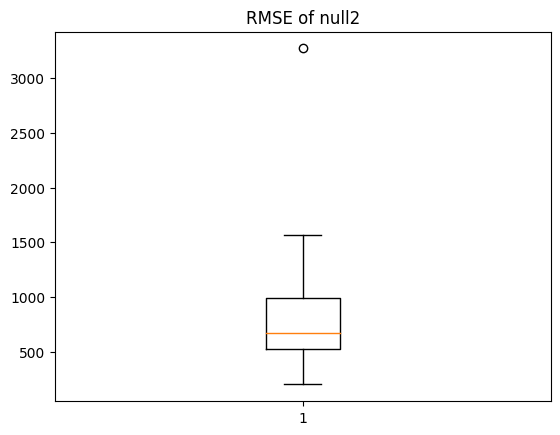

In [8]:
# K-fold, since the above is pretty random
from sklearn.model_selection import KFold

n = 50

nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
mses = {
    "null": [],
    "null2": [],
    "ada": [],
    "regressor": []
}

relavantAttributes = []

for train_idx, test_idx in nf_CV.split(X):
    # train-test split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    decisionTreeRegressor.fit(X_train, y_train)
    adaboostRegressor.fit(X_train, y_train)

    y_predict = decisionTreeRegressor.predict(X_test)
    y_predict2 = adaboostRegressor.predict(X_test)
    y_null_predict = [y_train.mean()] * len(X_test)
    y_null_2 = X_test["Last Offence Rate"]

    mse_regressor = mean_squared_error(y_test, y_predict)
    mse_ada = mean_squared_error(y_test, y_predict2)
    mse_null = mean_squared_error(y_test, y_null_predict)
    mse_null_2 = mean_squared_error(y_test, y_null_2)

    # if (np.sqrt(mse_ada) > 2000):
    #     print(X_test)
    #     print(y_test)

    # Get the summary of all attributes
    tree_rules = export_text(decisionTreeRegressor, feature_names=list(X_train))
    relavantAttributes.extend(getSplitAttributes(tree_rules))

    mses["ada"].append(mse_ada)
    mses["regressor"].append(mse_regressor)
    mses["null"].append(mse_null)
    mses["null2"].append(mse_null_2)

# Print the RMSE for each model
for key in mses:
    print("MSE of", key, ":", np.mean(mses[key]))
    print("RMSE of", key, ":", np.mean(np.sqrt(mses[key])))

print("Key precision comparison ratio")
print("Ada/Null2", np.mean(mses["ada"])/np.mean(mses["null2"]))
print(np.mean(mses["ada"])/np.mean(mses["null"]))
print("Regressor/Null2", np.mean(mses["regressor"])/np.mean(mses["null2"]))
print(np.mean(mses["regressor"])/np.mean(mses["null"]))

print("Used attributes for regressor tree: ")
print(pd.Series(relavantAttributes).value_counts())

plt.figure()
plt.title("RMSE of normal decision tree regressor")
plt.boxplot(np.sqrt(mses["regressor"]))
plt.show()

plt.figure()
plt.title("RMSE of ada")
plt.boxplot(np.sqrt(mses["ada"]))
plt.show()

plt.figure()
plt.title("RMSE of null2")
plt.boxplot(np.sqrt(mses["null2"]))
plt.show()
    